In [19]:
#TASK 1
#EDA and business insights





import pandas as pd

# Loading data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Viewing first few rows
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [20]:
# Checking for missing values
customers.isnull().sum(), products.isnull().sum(), transactions.isnull().sum()

# Removing duplicates
customers.drop_duplicates(inplace=True)
products.drop_duplicates(inplace=True)
transactions.drop_duplicates(inplace=True)


<AxesSubplot:title={'center':'Monthly Sales'}, xlabel='Month', ylabel='Count'>

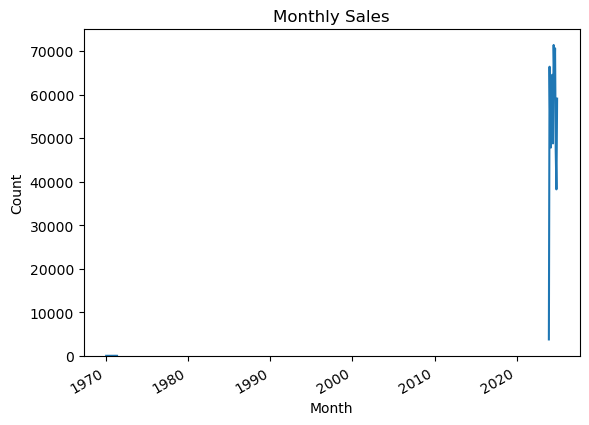

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of product prices
sns.histplot(products['Price'], kde=True)

# Sales over time
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Month'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('Month')['TotalValue'].sum()

monthly_sales.plot(kind='line', title="Monthly Sales")


In [22]:
# Task 2: Lookalike Model



# Merging the dataframes
merged_data = pd.merge(transactions, customers, on="CustomerID")
merged_data = pd.merge(merged_data, products, on="ProductID")


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Example: Create a simple profile based on total spending and product preferences
customer_profile = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Category': lambda x: ', '.join(x.unique())
}).reset_index()

# One-hot encoding for the product categories
# Convert the 'Category' column into a list of categories for each customer
categories = customer_profile['Category'].str.get_dummies(sep=', ')

# Merge the one-hot encoded categories back into the customer profile
customer_profile = pd.concat([customer_profile, categories], axis=1)

# Now, we can calculate the cosine similarity between the profiles, using only the numerical columns
# Drop non-numerical columns for cosine similarity (e.g., 'CustomerID' and original 'Category')
numerical_profile = customer_profile.drop(['CustomerID', 'Category'], axis=1)

# Apply cosine similarity between profiles
similarity_matrix = cosine_similarity(numerical_profile)

# Get the top 3 lookalikes for each customer
lookalikes = {}
for idx, row in enumerate(similarity_matrix):
    top_3_similar = row.argsort()[-4:-1]  # excluding itself
    lookalikes[customer_profile['CustomerID'].iloc[idx]] = [
        (customer_profile['CustomerID'].iloc[i], row[i]) for i in top_3_similar
    ]

# Display the lookalikes for the first 5 customers as an example
for customer, similar_customers in list(lookalikes.items())[:5]:
    print(f"Customer {customer} lookalikes: {similar_customers}")


Customer C0001 lookalikes: [('C0174', 0.9999999965896136), ('C0127', 0.9999999998112861), ('C0152', 0.9999999999885797)]
Customer C0002 lookalikes: [('C0134', 0.9999999732321261), ('C0062', 0.9999999946587943), ('C0159', 0.9999999970500387)]
Customer C0003 lookalikes: [('C0166', 0.9999999964251194), ('C0091', 0.9999999965133399), ('C0106', 0.9999999989303254)]
Customer C0004 lookalikes: [('C0018', 0.9999999992488021), ('C0012', 0.9999999999707885), ('C0148', 0.9999999999814015)]
Customer C0005 lookalikes: [('C0140', 0.9999999985531378), ('C0197', 0.9999999992756743), ('C0199', 0.9999999998136738)]


In [24]:
# Save the lookalikes
lookalike_df = pd.DataFrame(lookalikes.items(), columns=["CustomerID", "Lookalikes"])
lookalike_df.to_csv("Lookalike.csv", index=False)


In [25]:
print(lookalike_df)

    CustomerID                                         Lookalikes
0        C0001  [(C0174, 0.9999999965896136), (C0127, 0.999999...
1        C0002  [(C0134, 0.9999999732321261), (C0062, 0.999999...
2        C0003  [(C0166, 0.9999999964251194), (C0091, 0.999999...
3        C0004  [(C0018, 0.9999999992488021), (C0012, 0.999999...
4        C0005  [(C0140, 0.9999999985531378), (C0197, 0.999999...
..         ...                                                ...
194      C0196  [(C0138, 0.9999999992445368), (C0187, 0.999999...
195      C0197  [(C0005, 0.9999999992756743), (C0199, 0.999999...
196      C0198  [(C0029, 0.9999995798479103), (C0094, 0.999999...
197      C0199  [(C0140, 0.9999999994052496), (C0005, 0.999999...
198      C0200  [(C0113, 0.9999999999890827), (C0162, 0.999999...

[199 rows x 2 columns]


In [26]:
# Task 3: Customer Segmentation / Clustering





from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

# One-Hot Encoding for the 'Category' column
categories = customer_profile['Category'].str.get_dummies(sep=', ')

# Merge the one-hot encoded categories back into the customer profile
customer_profile_encoded = pd.concat([customer_profile.drop('Category', axis=1), categories], axis=1)

# Now, let's scale the numerical features (TotalValue, etc.)
# Note: Drop 'CustomerID' because it's not a feature, just an identifier
numerical_features = customer_profile_encoded.drop('CustomerID', axis=1)

# Apply scaling to the numerical features
scaler = StandardScaler()
profile_scaled = scaler.fit_transform(numerical_features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(profile_scaled)

# Add the cluster labels to the original dataframe
customer_profile_encoded['Cluster'] = clusters

# Compute the Davies-Bouldin Index (DB Index) to evaluate the clustering quality
db_index = davies_bouldin_score(profile_scaled, clusters)

# Output the DB Index
print(f'Davies-Bouldin Index: {db_index}')

# Optionally, let's inspect the first few rows of the data with the cluster labels
print(customer_profile_encoded.head())


Davies-Bouldin Index: 0.991635809266667
  CustomerID  TotalValue  Books  Clothing  Electronics  Home Decor  Books  \
0      C0001     3354.52      1         0            1           1      1   
1      C0002     1862.74      0         1            0           1      0   
2      C0003     2725.38      0         1            1           1      0   
3      C0004     5354.88      1         0            1           1      1   
4      C0005     2034.24      0         0            1           1      0   

   Clothing  Electronics  Home Decor  Cluster  
0         0            1           1        3  
1         1            0           1        0  
2         1            1           1        0  
3         0            1           1        3  
4         0            1           1        0  


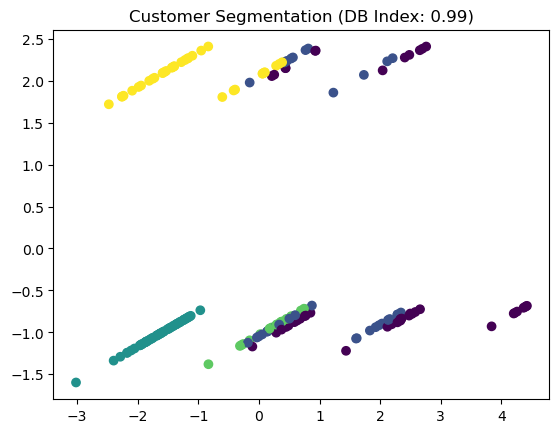

In [27]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(profile_scaled)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.title(f"Customer Segmentation (DB Index: {db_index:.2f})")
plt.show()
